In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Concentración inicial de depletantes
n_3           = 0.4                                              #Densidad numerica depletantes

# Concentración inicial relativa de coloides
k_0                = 1.0                                         #Cantidad relativa inicial de coloide llave
l_0                = 1.0                                         #Cantidad relativa inicial de coloide cerradura

# Parametros del sistema

sigma_3            = 1.0                                         #Diametro depletantes
sigma_1            = 10.0 * sigma_3                              #Diametro coloide cerradura
sigma_2_est        = 10.0 * sigma_3                              #Diametro coloide llave (1 corrida)
sigma_2_din        = np.loadtxt("beta_u_llave_cerradura_2D_contacto_sigma_2.csv", delimiter=",")[:,0]  #Diametro coloide llave (2 corrida)
dEC_est            = 5.0  * sigma_3                              #Distancia Cerradura - Hueco (2 corrida)
dEC_din            = np.loadtxt("beta_u_llave_cerradura_2D_contacto_dEC.csv", delimiter=",")[:,0]  #Distancia Cerradura - Hueco (1 corrida)


# Parametros del cálculo
delta_t            = 0.0005                                      #Intervalo de tiempo simulado                                    
t_max              = 75                                          #Tiempo maximo simulado     
t                  = np.arange(0,t_max,delta_t)                  #Escaleta de tiempo

# Matriz de concentraciones de los coloides
grado_avance       = np.zeros((len(t),2))

# Constantes empiricas de la reacción
alpha              = 1                                           #Constante empirica
lambda_            = 1                                           #Constante empirica

# Potenciales de reaccion
beta_u_ef_con_dEC  = np.loadtxt("beta_u_llave_cerradura_2D_contacto_dEC.csv", delimiter=",")[:,1]     #Potencial primer corrida
beta_u_ef_con_s_2  = np.loadtxt("beta_u_llave_cerradura_2D_contacto_sigma_2.csv", delimiter=",")[:,1] #Potencial segunda corrida

In [66]:
# Fuciones de modelan la forma de las EDOs para las concentraciones de coloides

def f_xi_1(n_0, lambda_, alpha, beta_u_ef_nor, l_0, k_0, xi_1, xi_2):
    beta_u_ef = beta_u_ef_nor * n_0 
    x         = - alpha * beta_u_ef + np.log( n_0 * lambda_ )
    return      np.exp( x ) * ( l_0 - xi_1 - xi_2 ) * ( k_0 - xi_1 ) - ( xi_1 - xi_2 ) 
    
def f_xi_2(n_0, lambda_, alpha, beta_u_ef_nor, l_0, k_0, xi_1, xi_2):
    beta_u_ef = beta_u_ef_nor * n_0 
    x         = - alpha * beta_u_ef + np.log( n_0 * lambda_ )
    return      np.exp( x ) * ( l_0 - xi_1 - xi_2 ) * ( xi_1 - xi_2 ) - xi_2
 

In [67]:
for z in range(2):
    if z==0: 
        #Colocar la primer lista de potenciales a usar
        beta_u_ef_a = beta_u_ef_con_dEC 
    else:
        #Colocar la segunda lista de potenciales a usar
        beta_u_ef_a = beta_u_ef_con_s_2
        
    for j in range(len(beta_u_ef_a)):
        beta_u_ef = beta_u_ef_a[j]

        if z==0:
            #Colocar la primer seleccion de parametros
            sigma_2 = sigma_2_est
            dEC     = dEC_din[j]
        else:
            #Colocar la segunda seleccion de parametros
            sigma_2 = sigma_2_din[j]
            dEC     = dEC_est
        
        for i in range(len(t)-1):
        # Pendientes necesarias para calcular los valores de conconcentracion de los coloides en
        # t = i*delta_t
            k1_xi_1 = f_xi_1(n_3, lambda_, alpha, beta_u_ef, l_0, k_0, grado_avance[i,0]                      , grado_avance[i,1] )
            k2_xi_1 = f_xi_1(n_3, lambda_, alpha, beta_u_ef, l_0, k_0, grado_avance[i,0] + (k1_xi_1/2)*delta_t, grado_avance[i,1] )
            k3_xi_1 = f_xi_1(n_3, lambda_, alpha, beta_u_ef, l_0, k_0, grado_avance[i,0] + (k2_xi_1/2)*delta_t, grado_avance[i,1] )
            k4_xi_1 = f_xi_1(n_3, lambda_, alpha, beta_u_ef, l_0, k_0, grado_avance[i,0] + k3_xi_1*delta_t    , grado_avance[i,1] )
        
            k1_xi_2 = f_xi_2(n_3, lambda_, alpha, beta_u_ef, l_0, k_0, grado_avance[i,0], grado_avance[i,1]                       )
            k2_xi_2 = f_xi_2(n_3, lambda_, alpha, beta_u_ef, l_0, k_0, grado_avance[i,0], grado_avance[i,1] + (k1_xi_2/2)*delta_t )
            k3_xi_2 = f_xi_2(n_3, lambda_, alpha, beta_u_ef, l_0, k_0, grado_avance[i,0], grado_avance[i,1] + (k2_xi_2/2)*delta_t )
            k4_xi_2 = f_xi_2(n_3, lambda_, alpha, beta_u_ef, l_0, k_0, grado_avance[i,0], grado_avance[i,1] + k3_xi_2*delta_t     )
        
        
            # Aplicar el algoritmo de calcular los valores de conconcentracion de los coloides en t = i*delta_t
            grado_avance[i+1,0] = grado_avance[i,0] + delta_t * ( k1_xi_1   + 2*k2_xi_1   + 2*k3_xi_1   + k4_xi_1 )/6
            grado_avance[i+1,1] = grado_avance[i,1] + delta_t * ( k1_xi_2   + 2*k2_xi_2   + 2*k3_xi_2   + k4_xi_2 )/6
          
        np.savetxt('Grado_avance_n3_'+ str(str(round(n_3,1))) + 
                '_sigma2_' + str(round(sigma_2,1)) + '_dEC_' + str(round(dEC,1)) + '.csv', grado_avance, delimiter=",")

        #Reiniciar la matriz de grado de avance
        grado_avance = np.zeros((len(t),2))

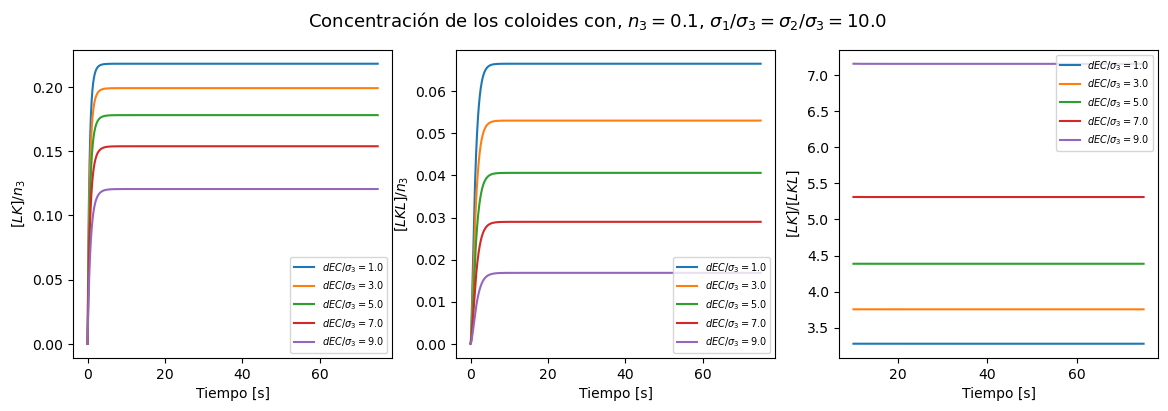

In [9]:
# Primera figura donde se varia dEC con 
# n3 = 0.1, sigma_1 = sigma=2 = 10*sigma_3

n_3           = 0.1
#Iniciar el grafico a usar
fig, axs = plt.subplots(1, 3, figsize=[14, 4])

for i in range(5):
    grado_avance =  np.loadtxt('Grado_avance_n3_'+ str(str(round(n_3,1))) + 
                '_sigma2_' + str(round(sigma_2_est,1)) + '_dEC_' + str(round(dEC_din[i],1)) + '.csv', delimiter=",") 

    LK_c         = grado_avance[:,0] - grado_avance[:,1]
    LKL_c        = grado_avance[:,1]
    
    axs[0].plot(t, LK_c      , label = r'$dEC/\sigma_3=$'+str(round(dEC_din[i],1)) )
    axs[1].plot(t, LKL_c     , label = r'$dEC/\sigma_3=$'+str(round(dEC_din[i],1)) )
    axs[2].plot(t[20000 :], LK_c[20000 :]/LKL_c[20000 :]     , label = r'$dEC/\sigma_3=$'+str(round(dEC_din[i],1)) )

axs[0].set_xlabel('Tiempo [s]')
axs[0].set_ylabel(r'$[LK]/n_3$')
axs[0].legend(prop={'size': 7})

axs[1].set_xlabel('Tiempo [s]')
axs[1].set_ylabel(r'$[LKL]/n_3$')
axs[1].legend(prop={'size': 7})

axs[2].set_xlabel('Tiempo [s]')
axs[2].set_ylabel(r'$[LK]/[LKL]$')
axs[2].legend(prop={'size': 7})


fig.suptitle(r'Concentración de los coloides con' + r', $n_3=$' + str(round(n_3,1)) +
             r', $\sigma_1/\sigma_3=\sigma_2/\sigma_3=$' + str(round(sigma_2_est,1)), fontsize=13)
plt.savefig("Grafico_dinamica_biensamblados_dEC_n3_0.1.png", dpi=500)
plt.show()

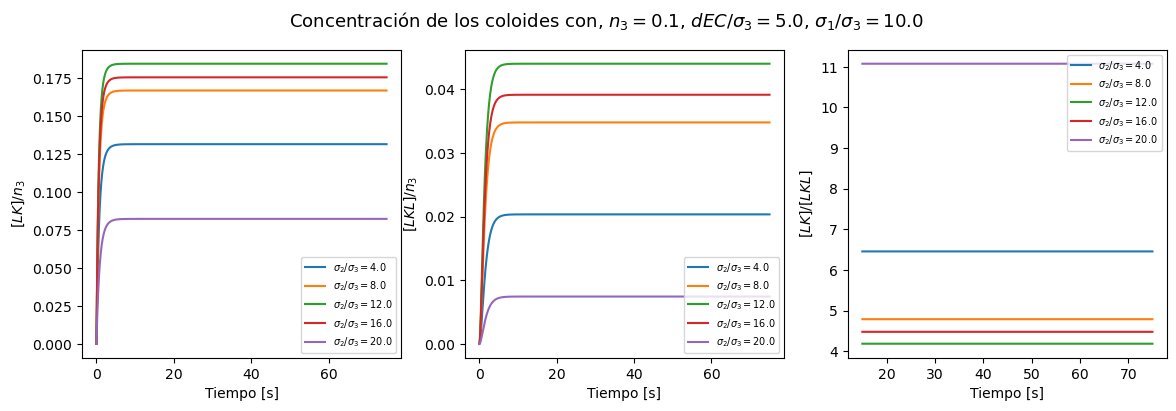

In [8]:
# Segunda figura donde se varia sigma_2 con 
# n3 = 0.1, sigma_1 =  10*sigma_3, dEC =  5*sigma_3

n_3           = 0.1
#Iniciar el grafico a usar
fig, axs = plt.subplots(1, 3, figsize=[14, 4])

for i in range(5):
    grado_avance =  np.loadtxt('Grado_avance_n3_'+ str(str(round(n_3,1))) + 
                '_sigma2_' + str(round(sigma_2_din[i],1)) + '_dEC_' + str(round(dEC_est,1)) + '.csv', delimiter=",") 

    LK_c         = grado_avance[:,0] - grado_avance[:,1]
    LKL_c        = grado_avance[:,1]
    
    axs[0].plot(t, LK_c      , label = r'$\sigma_2/\sigma_3=$'+str(round(sigma_2_din[i],1)) )
    axs[1].plot(t, LKL_c     , label = r'$\sigma_2/\sigma_3=$'+str(round(sigma_2_din[i],1)) )
    axs[2].plot(t[30000 :], LK_c[30000 :]/LKL_c[30000 :]     , label = r'$\sigma_2/\sigma_3=$'+str(round(sigma_2_din[i],1)) )

axs[0].set_xlabel('Tiempo [s]')
axs[0].set_ylabel(r'$[LK]/n_3$')
axs[0].legend(prop={'size': 7})

axs[1].set_xlabel('Tiempo [s]')
axs[1].set_ylabel(r'$[LKL]/n_3$')
axs[1].legend(prop={'size': 7})

axs[2].set_xlabel('Tiempo [s]')
axs[2].set_ylabel(r'$[LK]/[LKL]$')
axs[2].legend(prop={'size': 7})


fig.suptitle(r'Concentración de los coloides con' + r', $n_3=$' + str(round(n_3,1)) +
             r', $dEC/\sigma_3=$' + str(round(dEC_est,1))+
             r', $\sigma_1/\sigma_3=$' + str(round(sigma_1,1)), fontsize=13)
plt.savefig("Grafico_dinamica_biensamblados_sigma2_n3_0.1.png", dpi=500)
plt.show()

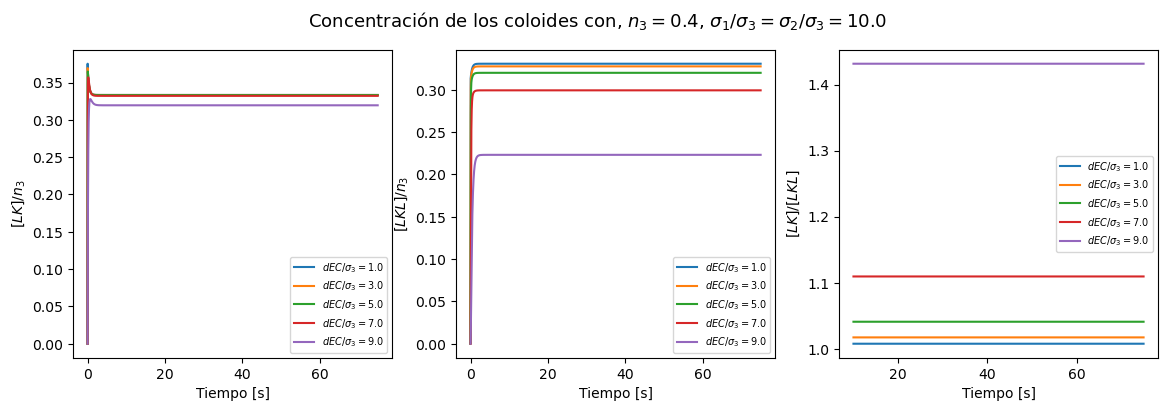

In [10]:
# Tercer figura donde se varia dEC con 
# n3 = 0.4, sigma_1 = sigma=2 = 10*sigma_3

n_3           = 0.4
#Iniciar el grafico a usar
fig, axs = plt.subplots(1, 3, figsize=[14, 4])

for i in range(5):
    grado_avance =  np.loadtxt('Grado_avance_n3_'+ str(str(round(n_3,1))) + 
                '_sigma2_' + str(round(sigma_2_est,1)) + '_dEC_' + str(round(dEC_din[i],1)) + '.csv', delimiter=",") 

    LK_c         = grado_avance[:,0] - grado_avance[:,1]
    LKL_c        = grado_avance[:,1]
    
    axs[0].plot(t, LK_c      , label = r'$dEC/\sigma_3=$'+str(round(dEC_din[i],1)) )
    axs[1].plot(t, LKL_c     , label = r'$dEC/\sigma_3=$'+str(round(dEC_din[i],1)) )
    axs[2].plot(t[20000 :], LK_c[20000 :]/LKL_c[20000 :]     , label = r'$dEC/\sigma_3=$'+str(round(dEC_din[i],1)) )

axs[0].set_xlabel('Tiempo [s]')
axs[0].set_ylabel(r'$[LK]/n_3$')
axs[0].legend(prop={'size': 7})

axs[1].set_xlabel('Tiempo [s]')
axs[1].set_ylabel(r'$[LKL]/n_3$')
axs[1].legend(prop={'size': 7})

axs[2].set_xlabel('Tiempo [s]')
axs[2].set_ylabel(r'$[LK]/[LKL]$')
axs[2].legend(prop={'size': 7})


fig.suptitle(r'Concentración de los coloides con' + r', $n_3=$' + str(round(n_3,1)) +
             r', $\sigma_1/\sigma_3=\sigma_2/\sigma_3=$' + str(round(sigma_2_est,1)), fontsize=13)
plt.savefig("Grafico_dinamica_biensamblados_dEC_n3_0.4.png", dpi=500)
plt.show()

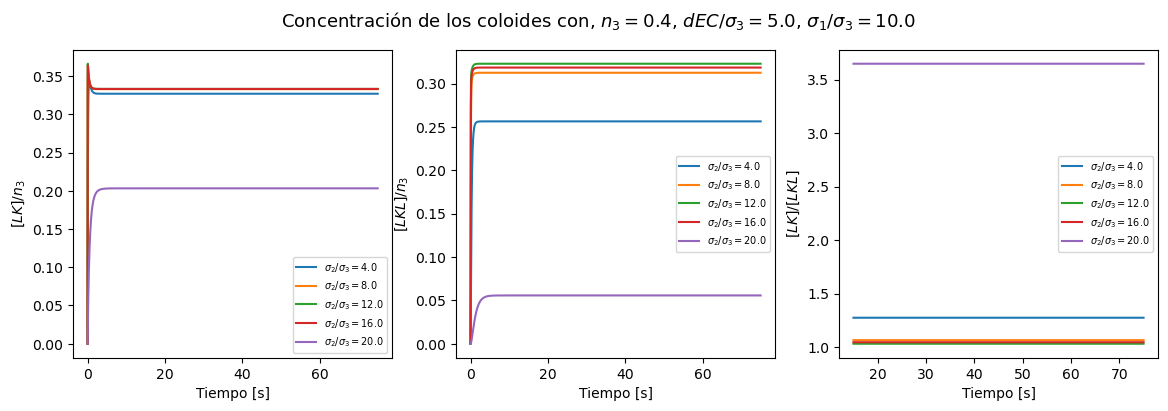

In [11]:
# Cuarta figura donde se varia sigma_2 con 
# n3 = 0.4, sigma_1 =  10*sigma_3, dEC =  5*sigma_3

n_3           = 0.4
#Iniciar el grafico a usar
fig, axs = plt.subplots(1, 3, figsize=[14, 4])

for i in range(5):
    grado_avance =  np.loadtxt('Grado_avance_n3_'+ str(str(round(n_3,1))) + 
                '_sigma2_' + str(round(sigma_2_din[i],1)) + '_dEC_' + str(round(dEC_est,1)) + '.csv', delimiter=",") 

    LK_c         = grado_avance[:,0] - grado_avance[:,1]
    LKL_c        = grado_avance[:,1]
    
    axs[0].plot(t, LK_c      , label = r'$\sigma_2/\sigma_3=$'+str(round(sigma_2_din[i],1)) )
    axs[1].plot(t, LKL_c     , label = r'$\sigma_2/\sigma_3=$'+str(round(sigma_2_din[i],1)) )
    axs[2].plot(t[30000 :], LK_c[30000 :]/LKL_c[30000 :]     , label = r'$\sigma_2/\sigma_3=$'+str(round(sigma_2_din[i],1)) )

axs[0].set_xlabel('Tiempo [s]')
axs[0].set_ylabel(r'$[LK]/n_3$')
axs[0].legend(prop={'size': 7})

axs[1].set_xlabel('Tiempo [s]')
axs[1].set_ylabel(r'$[LKL]/n_3$')
axs[1].legend(prop={'size': 7})

axs[2].set_xlabel('Tiempo [s]')
axs[2].set_ylabel(r'$[LK]/[LKL]$')
axs[2].legend(prop={'size': 7})


fig.suptitle(r'Concentración de los coloides con' + r', $n_3=$' + str(round(n_3,1)) +
             r', $dEC/\sigma_3=$' + str(round(dEC_est,1))+
             r', $\sigma_1/\sigma_3=$' + str(round(sigma_1,1)), fontsize=13)
plt.savefig("Grafico_dinamica_biensamblados_sigma2_n3_0.4.png", dpi=500)
plt.show()